In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

In [2]:
from multisoc.infer import data_loader
from multisoc.infer import wrappers
from multisoc.infer import aux_functions
from multisoc.generate.utils import make_composite_index
from multisoc.theory.fairness_metrics import *
from inequality_analysis_AddHealth import *

## Load the data
The nodes have three properties (shape, color, number) and their connections are stored in the edges dataframe.

In [3]:
nodes_dummy = pd.read_csv("./dummy_data/nodes_dummy.csv",index_col="index",dtype='category')
edges_dummy = pd.read_csv("./dummy_data/edges_dummy.csv",dtype='category')

In [ ]:
## The dummy data can also be downloaded from a pastebin repo

# import requests # pip install requests
# from io import StringIO

# edges_dummy_url = 'https://pastebin.com/raw/1pqauPwz'
# nodes_dummy_url = 'https://pastebin.com/raw/eNp61ptx'

# contents = requests.get(edges_dummy_url).text.split('\n')
# edges_dummy2 = pd.read_csv(StringIO("".join(contents)),dtype='category')

# contents = requests.get(nodes_dummy_url).text.split('\n')
# nodes_dummy2 = pd.read_csv(StringIO("".join(contents)),dtype='category',index_col="index")

## Explicitly choose the dimensions and categories in each dimension to perform the analysis

In [4]:
dimensions_list = ['number','color','shape']
num_dimensions = len(dimensions_list)

shape_list = ["Circle","Square"]
color_list = ["Blue","Red"]
number_list = ["1","2","3","4","5","6"]

all_attributes_dict = {
    "shape":shape_list,
    "color":color_list,
    "number":number_list
}

## Plot the network

In [6]:
## Build a networkx graph
G = nx.DiGraph()
for i, row in edges_dummy.iterrows():
    
    s = row["source"]
    t = row["target"]
    
    for node in [s,t]:
        if node not in G:
            attr_dict = {}
            for d in dimensions_list:
                attr_dict[d] = nodes_dummy[d][node]
            G.add_node(int(node),**attr_dict)

    G.add_edge(int(s),int(t))

In [7]:
## Setup node properties to plot
pos = nx.kamada_kawai_layout(G,scale=5)
nodelist = np.array(G.nodes())
node_color = np.array([G.nodes()[n]["color"] for n in nodelist])
node_shape = np.array([G.nodes()[n]["shape"] for n in nodelist])
n = len(G.nodes())
node_size = 40000*(1/(n+200))

degs = np.array([G.in_degree()[i] for i in nodelist])
node_size =  node_size*0.1+(node_size*4-node_size*0.1)*(degs-min(degs))/(max(degs)-min(degs))

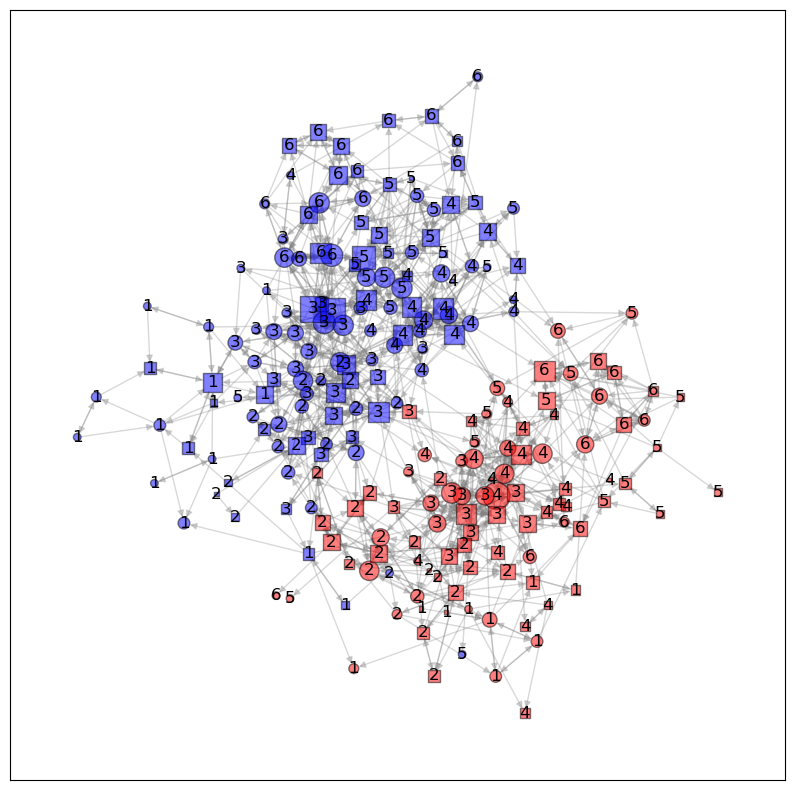

In [8]:
## Plot
plt.figure(figsize=(10,10))

shapes_dict = {"Square":"s","Circle":"o"}
for shape in shape_list:
    nx.draw_networkx_nodes(
        G,
        pos=pos,
        nodelist = nodelist[node_shape==shape],
        node_shape = shapes_dict[shape],
        node_color = node_color[node_shape==shape],
        node_size = node_size[node_shape==shape],
        alpha=0.5,
        edgecolors="k")

nx.draw_networkx_labels(
    G,
    pos=pos,
    labels = dict(G.nodes("number")),
    # alpha=0.8
                 )

nx.draw_networkx_edges(
    G,
    pos=pos,
    nodelist = nodelist,
    arrowstyle = '-|>',
    node_size = node_size,
    edge_color = 'grey',
    alpha=0.3)

plt.show()

## Convert the loaded data to adequate input
We include the nodes information in the edges dataframe so that the inference functions can process it.

In [9]:
nodes_input, edges_input = data_loader.build_nodes_edges_input_df(nodes_dummy, edges_dummy, dimensions=["shape","color","number"])

## Infer latent one-dimensional preferences

In [10]:
inferred_preferences = wrappers.infer_latent_preferences_1dSimple(
    nodes_input,
    edges_input,
    dimensions_list, 
    all_attributes_dict,
    type_p = "and" ## Type of aggregation function {and,or,mean}
    )

Likelihood maximization convergence result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


The dictionary of results contains:
- The multidimensional group sizes
- The number of links across multidimensional groups
- The one-dimensional group sizes
- The number of links across one-dimensional groups
- The inferred 1D latent preferences
- The diagonal-normalized 1D latent preferences
- The estimated multidimensional preferences computed with the aggregation function
- The model performance metrics (likelihood, AIC, BIC)

## Predict degree inequalities from inferred preferences

In [11]:
## Extract predicted H matrix
multidim_groups = list(itertools.product(*[all_attributes_dict[d] for d in dimensions_list]))
H = aux_functions.get_H_array_from_H_dataframe(inferred_preferences["H_multidimensional_preferences"],multidim_groups)

## Compute population fractions tensor and total number of nodes 
F = aux_functions.get_F_from_data(nodes_dummy,edges_dummy,all_attributes_dict,multidim_groups,dimensions_list)
N = np.sum(F)
assert N == len(nodes_dummy)
F = F/N

## Compute 1D inequalities
onedim_deltas_1vRest0 = analytical_1vRest_onedimensional_deltas(H,F,N)
onedim_deltas_1vRest = {dimensions_list[d]:{all_attributes_dict[dimensions_list[d]][k]:v for k,v in kv.items()} for d,kv in onedim_deltas_1vRest0.items()}

In [12]:
onedim_deltas_1vRest

{'number': {'1': -0.5783915545401846,
  '2': -0.16361056134296129,
  '3': 0.39666924482826627,
  '4': 0.10121525063633925,
  '5': -0.18203441516435634,
  '6': 0.23578878463116293},
 'color': {'Blue': 0.13604885114825244, 'Red': -0.1360488511482526},
 'shape': {'Circle': -0.05492696051125981, 'Square': 0.054926960511259816}}

## Compute empirical degree inequalities

In [13]:
ineq_emp = all_emp_ineq_from_nodes_edges_df(
    nodes_dummy,
    edges_dummy,
    dimensions_list)

In [14]:
pprint (ineq_emp)

{'color': {'Blue': 0.10953947368421058, 'Red': -0.10953947368421058},
 'number': {'1': -0.4763764154627098,
            '2': -0.07918968692449357,
            '3': 0.3233875063484002,
            '4': 0.033458177278401946,
            '5': -0.15530656707127288,
            '6': 0.20042539267015713},
 'shape': {'Circle': -0.04777992277992282, 'Square': 0.04777992277992271}}


## Plot inequalities

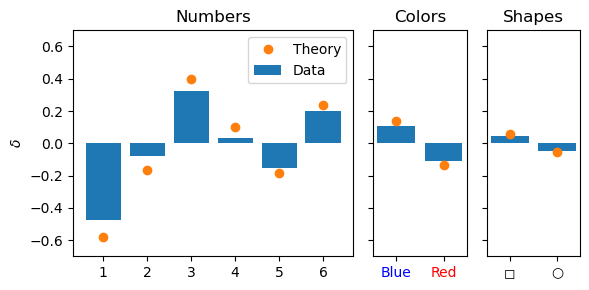

In [15]:
fig, axs = plt.subplots(1,3,width_ratios=[6,2,2],sharey=True,figsize=(6,3))

plt.sca(axs[0])
plt.title("Numbers")
x = number_list
y = [ineq_emp["number"][i] for i in x]
x2,y2 = zip(*list(onedim_deltas_1vRest["number"].items()))

plt.bar(x,y,label="Data")
y2 = np.array(y2)
plt.plot(x2,y2,"o",color="C1",label="Theory")

plt.ylabel(r"$\delta$")
plt.legend()

plt.sca(axs[1])
plt.title("Colors")
x, y = zip(*list(ineq_emp["color"].items()))
x2,y2 = zip(*list(onedim_deltas_1vRest["color"].items()))

plt.bar(x,y)
y2 = np.array(y2)
plt.plot(x2,y2,"o",color="C1")

for val,label in enumerate(axs[1].get_xticklabels()):
    label.set_color(label.get_text())

plt.sca(axs[2])
plt.title("Shapes")
x, y = zip(*list(ineq_emp["shape"].items()))
x2,y2 = zip(*list(onedim_deltas_1vRest["shape"].items()))

new_labels = {"Square":"◻","Circle":"○"}
x_new = [new_labels[i] for i in x]
plt.bar(x_new,y)

x_new2 = [new_labels[i] for i in x2]
y2 = np.array(y2)
plt.plot(x_new2,y2,"o",color="C1")

plt.ylim(-0.7,0.7)

plt.tight_layout()
plt.show()